# Fit, Optimize and Evaluate A Classifier


## Background

Now that we've extracted training data from the ODC, we can train a machine learning model. There are various classification models available, and deciding which one to pick depends on the classification task at-hand. The table below provides a useful summary of the pros and cons of different models (all of which are available through [scikit-Learn](https://scikit-learn.org/stable/)). This sckit-learn [cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) may also help. _Table 1: Some of the pros and cons of different classifiers available through scikit-learn_
<img align="center" src="../../../Supplementary_data/Scalable_machine_learning/classifier_pro_cons.png" width="700">


In this example We are using Random Forest classifier for the land cover classification task. We'll split the data into a training and testing set and use k-fold cross-validation to estimate the prediction ability of our model. To make full use of the limited number of training dara, here we will fit the final model on _all_ the training data.

## Description

This notebook runs through evaluating, optimizing, and fitting a machine learning classifier (in the default example, a Random Forest model is used). Under each of the sub-headings you will find more information on how and why each method is used. The steps are as follows:

1. Set up some parameters and import the training data
2. Optimize the hyperparameters of the model
3. Fit a model to all the training data using the best hyperparameters identified in the previous step
4. Calculate an unbiased performance estimate via cross-validation
5. Save the model to disk for use in the subsequent notebook, `3_Land_Cover_Classification.ipynb`

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

## Load packages

In [78]:
%matplotlib inline
import os
import datacube
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.io.cgroups import get_cpu_quota
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from joblib import dump

## Analysis Parameters

* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_Training_Data.ipynb`
* `dict_map` : A dictionary map of class names corresponding to pixel values.
* `class_attr` : This is the name of column in your shapefile attribute table that contains the class labels.

In [65]:
# training_data='Results/Lesotho_landcover_training_data_2021_filtered.txt'
training_data='Results/landcover_td2021_filtered_DEAfrica_newest.txt'
dict_map={'Urban':1,'Cropland':2,'Trees':4,'Water':6,'Wetland':7,'Shrubland':9,'Grassland':10,'Barren':12,'Irrigated_Agriculture':14}
# dict_map={1:'Dense Forest',2:'Open Forest',6:'Open Grassland',8:'Wooded Grassland',10:'Cropland',11:'Vegetated Wetland',12:'Open Water',13:'Settlements'}
# dict_map={1:'Water',2:'Cropland',3:'Trees',4:'Bare Surface',5:'Shrubland/Grassland'}
class_attr = 'LC_Class_I' # class label in integer format

## Import training data

In [67]:
# load training data as pandas dataframe
df_training_data= pd.read_csv(training_data,delimiter=' ')
# Plot first five rows
df_training_data.head()

,LC_Class_I,blue_0,blue_1,blue_2,blue_3,blue_4,blue_5,green_0,green_1,green_2,...,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,x_coord,y_coord,geometry,cluster,cluster_frequency
0,1.0,392.443787,411.736511,484.599304,580.716187,597.883362,521.160828,702.979492,700.031860,820.554688,...,0.525062,0.396864,0.249766,0.347274,0.499634,582635.0,6649875.0,POINT (582635 6649875),1,0.139
1,1.0,574.963257,367.174896,367.352203,477.944275,545.210083,535.651123,855.891907,692.017151,599.237000,...,0.574066,0.412703,0.283654,0.384707,0.491538,580745.0,6648685.0,POINT (580745 6648685),1,0.139
2,1.0,552.944946,471.750641,514.148010,677.836243,672.473816,459.239807,885.540771,692.555054,699.613220,...,0.478700,0.357840,0.203101,0.319174,0.548070,610015.0,6659045.0,POINT (610015 6659045),1,0.139
3,1.0,905.797424,844.184326,832.719666,906.122070,1039.482422,1118.225708,1182.149414,1177.120728,1120.216431,...,0.217357,0.158323,0.137693,0.145437,0.154948,652625.0,6672015.0,POINT (652625 6672015),3,0.256
4,1.0,579.446960,543.148193,642.078491,708.081482,721.028748,708.530273,921.100769,863.758423,929.162170,...,0.302353,0.211847,0.179304,0.216355,0.292293,630855.0,6675075.0,POINT (630855 6675075),3,0.256


In [68]:
# slicing the dataframe to exclude the coordinates and/or geometry columns (last columns) if exist
df_training_data=df_training_data.iloc[:,:-5]

A common problem with training data is **class imbalance**. This can occur when one of your classes is relatively rare and therefore the rare class will comprise a smaller proportion of the training set. When imbalanced data is used, it is common that the final classification will under-predict less abundant classes relative to their true proportion. We can plot the number of the extracted training data for each class, to check if the training samples are imbalanced among classes:

Text(0.5, 0, 'Land Cover Class')

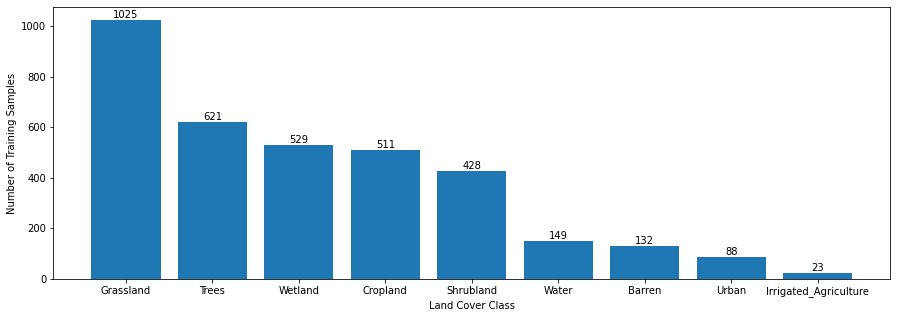

In [69]:
# count numbers of classes
class_counts=df_training_data[class_attr].value_counts()

# get class names
class_indices=class_counts.index
class_legends=[key for class_index in class_indices for key, value in dict_map.items() if value==class_index]

# plot training samples distribution
plt.figure(figsize=(15,5))
ax=plt.bar(class_legends,height=class_counts.to_numpy())
plt.bar_label(ax)
plt.gca().set_ylabel('Number of Training Samples')
plt.gca().set_xlabel('Land Cover Class')

If you think your data is imbalanced, you may consider adding more training samples for under-represented classes or removing samples for over-represented classes.

In [70]:
n_trees_train=len(df_training_data[df_training_data[class_attr]==dict_map['Trees']])
n_wetland_train=len(df_training_data[df_training_data[class_attr]==dict_map['Wetland']])
if n_trees_train>300: # limit to 300
    print('Number of training samples for Trees: ',n_trees_train)
    indices_drop=df_training_data[df_training_data[class_attr]==dict_map['Trees']].sample(n=n_trees_train-300).index
    df_training_data=df_training_data.drop(indices_drop).reset_index(drop=True)
if n_wetland_train>150: # limit to 150
    print('Number of training samples for Wetlands: ',n_wetland_train)
    indices_drop=df_training_data[df_training_data[class_attr]==dict_map['Wetland']].sample(n=n_wetland_train-150).index
    df_training_data=df_training_data.drop(indices_drop).reset_index(drop=True)
print("Training data shape after rebalancing classes:", df_training_data.shape)

Number of training samples for Trees:  621
Number of training samples for Wetlands:  529
Training data shape after rebalancing classes: (2806, 67)


## Optimize hyperparameters

Machine learning models require certain 'hyperparameters': model parameters that can be tuned to increase the prediction ability of a model. Finding the best values for these parameters is a 'hyperparameter search' or an 'hyperparameter optimization'.

To optimize the parameters in our model, we use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to exhaustively search through a set of parameters and determine the combination that will result in the highest accuracy based upon the accuracy metric defined. We first need to define a grid of parameters to be used in the optimization:
* `grid_parameters`: a dictionary of model specific parameters to search through during hyperparameter optimization.

> **Note**: the parameters in the `grid_parameters` object depend on the classifier being used. The default example is set up for a Random Forest classifier. To adjust the parameters to suit a different classifier, look up the important parameters under the relevant [sklearn documentation](https://scikit-learn.org/stable/supervised_learning.html).

In [71]:
# Create the parameter grid based on the results of random search 
grid_parameters={'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)],
                 'max_features': ['sqrt', 'log2'],'max_samples':[0.5]}

We now start searching for the optimal hyperparameters using `GridSearchCV`:

In [72]:
# initialise a random forest classifier
rf = RandomForestClassifier()

# stratified K-fold splitting strategy for grid search
cv=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=0) 

# detect the number of CPUs
ncpus=round(get_cpu_quota())
print('ncpus = '+str(ncpus))

# grid search to find optimal random forest classifier hyperparameters
print('Grid searching best hyper-parameters...')
grid_search=model_selection.GridSearchCV(estimator = rf,param_grid=grid_parameters,cv=cv,n_jobs=ncpus)

#convert variable names into sci-kit learn nomenclature
X = df_training_data.to_numpy()[:,1:] # abandon coordinate columns
y = df_training_data.to_numpy()[:,0]

# fit to all the data
grid_search.fit(X,y)
print('Optimal parameters: \n',grid_search.best_params_)

ncpus = 4
Grid searching best hyper-parameters...
Optimal parameters: 
 {'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 100}


## Fit the model

Using the best parameters from our hyperparmeter optimization search, we now fit our model on all the data.

In [73]:
rf = RandomForestClassifier(**grid_search.best_params_, random_state=1, n_jobs=ncpus)
rf.fit(X,y)

RandomForestClassifier(max_features='sqrt', max_samples=0.5, n_jobs=4,
                       random_state=1)

## Determine Feature Importance

Here we extract classifier estimates of the relative importance of each feature for training a Random Forest classifier. This is useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). However, in this case, we are not selecting a subset of features, but rather just trying to understand the importance of each feature. This can help us not only understand our classes better (e.g. what kinds of measurements are more important in predicting the land cover classes), but can also lead to further improvements to the model. 

Sklearn has good documentation on different methods for [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html).

Results will be presented in ascending order with the most important features listed last. Importance is reported as a relative fraction between 0 and 1. These importances are based on how much a given feature, on average, decreases the weighted Gini impurity.


Text(0, 0.5, 'Importance')

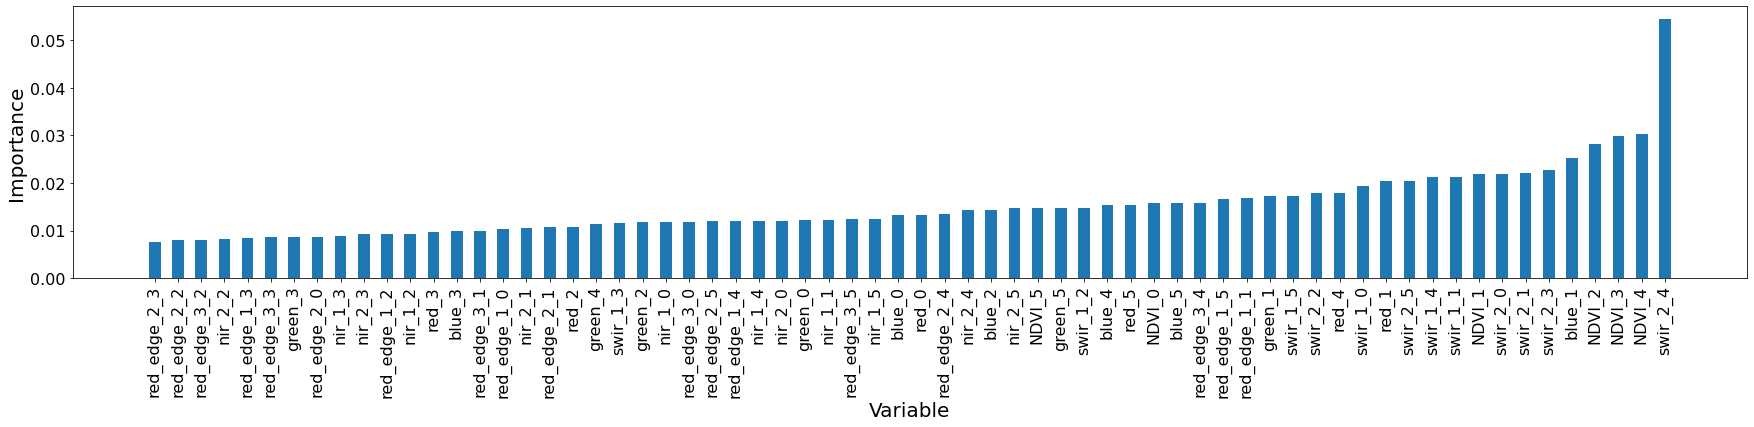

In [74]:
# sort feature importance
feat_importance_indices=np.argsort(rf.feature_importances_)[-10:]

# plot feature importance
plt.figure(figsize=(30,5))
order=np.argsort(rf.feature_importances_)
plt.bar(x=np.array(df_training_data.columns[1:])[order],height=rf.feature_importances_[order],width=0.5,align='center')
plt.xticks(rotation='vertical',fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Variable', fontsize=20)
plt.ylabel('Importance', fontsize=20)

According to the the feature importance method of the `RandomForestClassifier` we fitted to our data, the NDVI, swir_2 and swir_1 bands are our most important features for discriminating different classes in our selected area. 

## Evaluate performance via cross-validation

K-fold [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is a statistical method used to estimate the performance of machine learning models when making predictions on data not used during training.  It is a popular method because it is conceptually straightforward and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split. This procedure can be used both when optimizing the hyperparameters of a model on a dataset, and when comparing and selecting a model for the dataset. 

Since our training dataset is small and to make sure each class has samples in the training set, in this example the `StratifiedKFold` splitting is used. Stratified k-fold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set. We define 5 folds splitting, which divides the dataset into 5 sets:

In [ ]:
# stratified K-fold splitting
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
# skf=model_selection.KFold(n_splits=5,shuffle=True,random_state=1)

We now use `cross_val_score` function which calculates an accuracy score that show how well our classifier is doing at recognising points in each test split through cross validation. The default example is set up to calculate the `accuracy_score` or Overall Accuracy (OA), which is the fraction of correct predictions for all the samples. The OA will be between 0 and 1, with a value of 1 indicating a perfect score. There are other scoring paramters that you can choose [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [ ]:
# calculate overall accurcy through cross validation
overall_acc=model_selection.cross_val_score(rf,X,y,cv=skf,scoring='accuracy')
print('Overall accuracy from cross validation: ',np.mean(overall_acc))

To show how the prediction performs on each class, the example will calculate the predictions from cross validation:

In [ ]:
# predict through cross validation
predictions=model_selection.cross_val_predict(rf,X,y,cv=skf)

Using the predicted labels, we can calculate class-wise scores, such as precision and recall. The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0. We use the function `precision_score` for the calculation:

In [89]:
precision=precision_score(y,predictions,labels=list(dict_map.values()),average=None)
print('Precision for each class: \n',dict(zip(dict_map.keys(),np.around(precision,3))))

Precision for each class: 
 {'Urban': 0.333, 'Cropland': 0.74, 'Trees': 0.864, 'Water': 0.942, 'Wetland': 0.736, 'Shrubland': 0.518, 'Grassland': 0.636, 'Barren': 0.647, 'Irrigated_Agriculture': 1.0}


Similarly we can calculate the recall scores using the function `recall_score`. The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [90]:
recall=recall_score(y,predictions,labels=list(dict_map.values()),average=None)
print('Recall for each class: \n',dict(zip(dict_map.keys(),np.around(recall,3))))

Recall for each class: 
 {'Urban': 0.034, 'Cropland': 0.773, 'Trees': 0.827, 'Water': 0.866, 'Wetland': 0.613, 'Shrubland': 0.299, 'Grassland': 0.856, 'Barren': 0.417, 'Irrigated_Agriculture': 0.13}


To further inspect the actual numbers of predictions for each class we calculate and plot the `confusion_matrix`. The `confusion_matrix` By definition, entry *i, j* in a confusion matrix is the number of observations actually in group *i*, but predicted to be in group *j*:

Text(0.5, 1.0, 'Confusion Matrix')

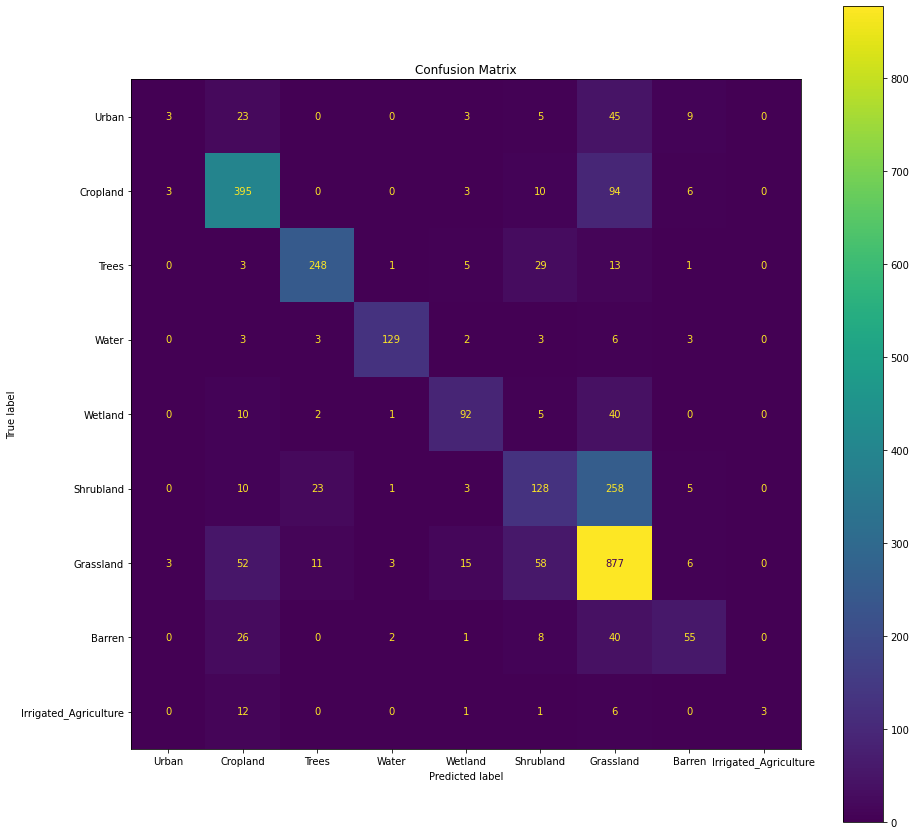

In [92]:
# generate and visualise confusion matrix
cm=confusion_matrix(y, predictions)
display_labels=[key for class_index in rf.classes_ for key, value in dict_map.items() if value==class_index]
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix')

## Save the model
We now export the trained classifier as a binary`.joblib` file, which will allow for importing the model in the subsequent script, `3_Land_Cover_Classification.ipynb` 

In [93]:
dump(rf, 'Results/Lesotho_RF_model.joblib')

['Results/Lesotho_RF_model.joblib']